In [1]:
from tools import make_cases

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
cases = make_cases('court_cases_sample/success/')

In [3]:
df_cases = pd.DataFrame(cases)
df_accounts = pd.read_csv('df_accounts_sample.csv', index_col=0)
df_bankruptcies = pd.read_csv('df_bankruptcies_sample.csv', index_col=0)

In [ ]:
df_cases.info()

In [ ]:
df_accounts.info()

In [4]:
df_cases.head()

,inn,resultType,caseNo,caseDate,instanceDate,caseType,sum,type
0,5414100369,Не удалось определить,А45-919/2017,2017-01-23T00:00:00,2017-01-24T00:00:00,5,18615950.0,0
1,5414100369,Проиграно,А45-11656/2016,2016-06-06T00:00:00,2016-10-13T00:00:00,6,175795.31,1
2,5414100369,Проиграно,А45-23060/2015,2015-11-02T00:00:00,2018-11-08T05:44:31,1,194788.98,1
3,1508000122,Не удалось определить,А61-1415/2020,2020-05-18T00:00:00,2020-09-23T18:18:09,6,0.0,1
4,1508000122,Не выиграно,А61-3399/2019,2019-07-12T00:00:00,2019-12-27T00:00:00,5,0.0,0


In [5]:
df_accounts.head()

,inn,year,long_term_liabilities_fiscal_year,short_term_liabilities_fiscal_year,balance_assets_fiscal_year,okei
0,2465002653,2012,0.0,113756,122240,384
1,3505003270,2012,21461.0,20211,81132,384
2,3517003250,2012,0.0,0,48063,384
3,5501078737,2012,0.0,288763,419522,384
4,6140019517,2012,0.0,0,11089,384


In [6]:
df_bankruptcies.head()

,bankrupt_id,bancrupt_year,inn
0,79546,2015,5620006322
1,76594,2015,2111008200
2,94301,2016,5414100369
3,93799,2019,2347009476
4,199671,2018,7224008489


In [7]:
df_cases.shape, df_accounts.shape, df_bankruptcies.shape

((8449, 8), (1035, 6), (106, 3))

In [8]:
df_cases['caseDate'] = pd.to_datetime(df_cases['caseDate'], errors='coerce')
df_cases['instanceDate'] = pd.to_datetime(df_cases['instanceDate'], errors='coerce')

df_cases['caseYear'] = df_cases['caseDate'].apply(lambda x: x.year)
df_cases['instanceYear'] = df_cases['instanceDate'].apply(lambda x: x.year)

df_cases.drop(['caseDate', 'instanceDate'], axis=1, inplace=True)

In [9]:
cols = [col for col in df_accounts.columns if '_year' in col]
df_accounts.loc[df_accounts['okei'] == 384, cols] = df_accounts * 1000
df_accounts.drop('okei', axis=1, inplace=True)

In [10]:
df = pd.DataFrame({'inn': np.sort(df_accounts['inn'].unique())})
df['is_bankrupt'] = 0
df['bancrupt_year'] = 0

In [11]:
df.head()

,inn,is_bankrupt,bancrupt_year
0,1001003743,0,0
1,1020010136,0,0
2,1203000142,0,0
3,1302000640,0,0
4,1411004211,0,0


In [12]:
df.loc[df['inn'].isin(df_bankruptcies['inn'].unique()), 'is_bankrupt'] = 1
df.head()

,inn,is_bankrupt,bancrupt_year
0,1001003743,0,0
1,1020010136,1,0
2,1203000142,1,0
3,1302000640,1,0
4,1411004211,1,0


In [13]:
df.loc[df['inn'].isin(df_bankruptcies['inn'].unique()), 'bancrupt_year'] = df_bankruptcies['bancrupt_year']

In [14]:
df.head()

,inn,is_bankrupt,bancrupt_year
0,1001003743,0,0.0
1,1020010136,1,2015.0
2,1203000142,1,2016.0
3,1302000640,1,2019.0
4,1411004211,1,2018.0


In [15]:
len(set(df_cases['inn']) - set(df['inn'])) > 0

True

In [16]:
df_cases = df_cases[df_cases['inn'].isin(df['inn'])]

In [17]:
merged_cases = df_cases.merge(df, on='inn')

In [18]:
merged_cases['inn'].unique().shape

(166,)

In [19]:
merged_cases = merged_cases[~((merged_cases['is_bankrupt'] == 1) & (merged_cases['instanceYear'] > merged_cases['bancrupt_year']))]

In [20]:
merged_cases.head()

,inn,resultType,caseNo,caseType,sum,type,caseYear,instanceYear,is_bankrupt,bancrupt_year
0,5414100369,Не удалось определить,А45-919/2017,5,18615950.0,0,2017.0,2017.0,1,2019.0
1,5414100369,Проиграно,А45-11656/2016,6,175795.31,1,2016.0,2016.0,1,2019.0
2,5414100369,Проиграно,А45-23060/2015,1,194788.98,1,2015.0,2018.0,1,2019.0
3,1508000122,Не удалось определить,А61-1415/2020,6,0.0,1,2020.0,2020.0,1,2021.0
4,1508000122,Не выиграно,А61-3399/2019,5,0.0,0,2019.0,2019.0,1,2021.0


In [21]:
result_type_pivot = pd.pivot_table(data=merged_cases,
                                   values='caseNo',
                                   index='inn',
                                   columns=['resultType'],
                                   aggfunc=pd.Series.nunique,
                                   fill_value=0)

In [22]:
result_type_pivot.head()

resultType,В иске отказано полностью,В иске отказано частично,Выиграно,Иск не рассмотрен,Иск полностью удовлетворен,Иск частично удовлетворен,"Иск частично удовлетворен, встречный не удовлетворен",Не выиграно,Не проиграно,Не удалось определить,Прекращено производство по делу,Проиграно,Утверждено мировое соглашение,Частично выиграно,Частично проиграно
inn,,,,,,,,,,,,,,,
1001003743,0,0,1,0,0,0,0,0,0,2,0,0,0,1,0
1203000142,2,0,12,0,5,1,0,3,9,136,0,7,0,7,7
1302000640,0,0,0,0,0,0,0,0,0,7,0,2,0,0,0
1411004211,0,0,0,0,1,0,0,0,0,4,0,9,0,0,2
1429006530,1,0,0,1,1,0,0,0,1,10,0,15,0,0,3


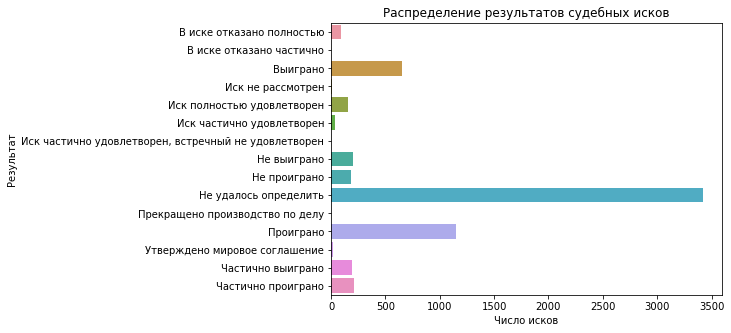

In [23]:
plt.figure(figsize=(7, 5))
sns.barplot(x=result_type_pivot.sum().values, y=result_type_pivot.sum().index)
plt.title('Распределение результатов судебных исков')
plt.xlabel('Число исков')
plt.ylabel('Результат')
plt.show()

In [24]:
to_rename = {
    'В иске отказано полностью': 'completely_denied',
    'В иске отказано частично': 'partially_denied',
    'Выиграно': 'won',
    'Иск не рассмотрен': 'not_considered',
    'Иск полностью удовлетворен': 'fully_satisfied',
    'Иск частично удовлетворен': 'partially_satisfied',
    'Иск частично удовлетворен, встречный не удовлетворен': 'partially_satisfied_counterclaim_not',
    'Не выиграно': 'not_won',
    'Не проиграно': 'not_lost',
    'Не удалось определить': 'couldnt_determine',
    'Прекращено производство по делу': 'case_were_terminated',
    'Проиграно': 'lost',
    'Утверждено мировое соглашение': 'settlement_agreement',
    'Частично выиграно': 'partially_won',
    'Частично проиграно': 'partially_lost'
}

result_type_pivot.rename(columns=to_rename, inplace=True)

In [25]:
result_type_pivot.head()

resultType,completely_denied,partially_denied,won,not_considered,fully_satisfied,partially_satisfied,partially_satisfied_counterclaim_not,not_won,not_lost,couldnt_determine,case_were_terminated,lost,settlement_agreement,partially_won,partially_lost
inn,,,,,,,,,,,,,,,
1001003743,0,0,1,0,0,0,0,0,0,2,0,0,0,1,0
1203000142,2,0,12,0,5,1,0,3,9,136,0,7,0,7,7
1302000640,0,0,0,0,0,0,0,0,0,7,0,2,0,0,0
1411004211,0,0,0,0,1,0,0,0,0,4,0,9,0,0,2
1429006530,1,0,0,1,1,0,0,0,1,10,0,15,0,0,3


In [26]:
case_type_pivot = pd.pivot_table(data=merged_cases,
                                 values='caseNo',
                                 index='inn',
                                 columns=['caseType'],
                                 aggfunc=pd.Series.nunique,
                                 fill_value=0)

In [27]:
case_type_pivot.head()

caseType,1,3,4,5,6,73,90
inn,,,,,,,
1001003743,0,0,0,2,2,0,0
1203000142,7,0,0,80,98,0,2
1302000640,2,0,0,3,4,0,0
1411004211,2,0,0,0,14,0,0
1429006530,0,0,0,1,31,0,0


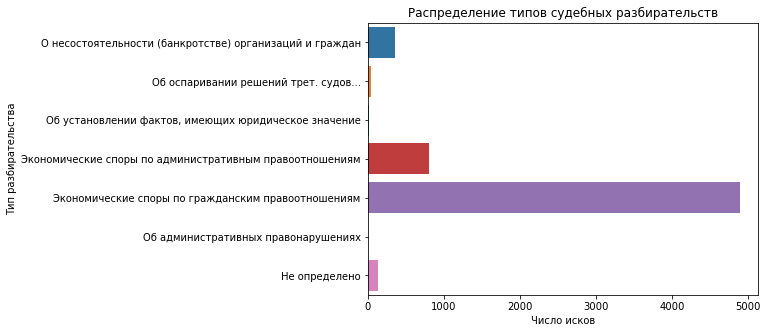

In [28]:
plt.figure(figsize=(7, 5))
g = sns.barplot(x=case_type_pivot.sum().values, y=case_type_pivot.sum().index)
plt.title('Распределение типов судебных разбирательств')
plt.xlabel('Число исков')
plt.ylabel('Тип разбирательства')
ticks = [
    'О несостоятельности (банкротстве) организаций и граждан',
    'Об оспаривании решений трет. судов...',
    'Об установлении фактов, имеющих юридическое значение',
    'Экономические споры по административным правоотношениям',
    'Экономические споры по гражданским правоотношениям',
    'Об административных правонарушениях',
    'Не определено'
]
g.set_yticklabels(ticks)
plt.show()

In [29]:
case_type_pivot = case_type_pivot.add_prefix('case_type_')

In [30]:
side_type_pivot = pd.pivot_table(data=merged_cases,
                                 values='caseNo',
                                 index='inn',
                                 columns=['type'],
                                 aggfunc=pd.Series.nunique, 
                                 fill_value=0)

In [31]:
side_type_pivot.head()

type,0,1,2,3
inn,,,,
1001003743,4,0,0,0
1203000142,90,86,13,4
1302000640,3,6,0,0
1411004211,1,15,1,0
1429006530,0,29,1,2


In [32]:
side_type_pivot = side_type_pivot.add_prefix('side_type_')

In [33]:
for table in [result_type_pivot, case_type_pivot, side_type_pivot]:
    table.reset_index(inplace=True)
    table.columns.name = None

In [34]:
side_type_pivot

,inn,side_type_0,side_type_1,side_type_2,side_type_3
0,1001003743,4,0,0,0
1,1203000142,90,86,13,4
2,1302000640,3,6,0,0
3,1411004211,1,15,1,0
4,1429006530,0,29,1,2
...,...,...,...,...,...
155,8617004112,0,27,1,0
156,8901998318,0,1,0,0
157,8908001998,6,16,3,0
158,8909000186,1,29,0,0


In [35]:
result_df_by_cases = result_type_pivot.merge(case_type_pivot, on='inn') \
    .merge(side_type_pivot, on='inn')

In [36]:
result_df_by_cases.head()

,inn,completely_denied,partially_denied,won,not_considered,fully_satisfied,partially_satisfied,partially_satisfied_counterclaim_not,not_won,not_lost,...,case_type_3,case_type_4,case_type_5,case_type_6,case_type_73,case_type_90,side_type_0,side_type_1,side_type_2,side_type_3
0,1001003743,0,0,1,0,0,0,0,0,0,...,0,0,2,2,0,0,4,0,0,0
1,1203000142,2,0,12,0,5,1,0,3,9,...,0,0,80,98,0,2,90,86,13,4
2,1302000640,0,0,0,0,0,0,0,0,0,...,0,0,3,4,0,0,3,6,0,0
3,1411004211,0,0,0,0,1,0,0,0,0,...,0,0,0,14,0,0,1,15,1,0
4,1429006530,1,0,0,1,1,0,0,0,1,...,0,0,1,31,0,0,0,29,1,2


In [37]:
df = df[df['inn'].isin(result_df_by_cases['inn'].unique())]

In [40]:
df_accounts = df_accounts[df_accounts['inn'].isin(result_df_by_cases['inn'].unique())]